# Monash University
# FIT5202 - Data processing for Big Data
# Assignment 1: Analyzing Road Crash Data




## 1. Working with RDD (25%)


### 1.1 Data Preparation and Loading (5%)

### Write the code to create a SparkContext object using SparkSession, which tells Spark how to access a cluster. To create a SparkSession you first need to build a SparkConf object that contains information about your application. Give an appropriate name for your application and run Spark locally with as many working processors as logical cores on your machine.

In [1]:
# Importing required libraries and functions
from pyspark import SparkConf
from pyspark.rdd import RDD
from pyspark.sql.functions import col
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType
import pandas
import pyspark.sql.functions as fn 
from pyspark.sql.functions import rank,sum,col
from pyspark.sql import Window
from pyspark.sql.functions import isnan
import math
import pandas as pd
import matplotlib as plt

# local[*]: run Spark in local mode with as many working processors as logical cores on your machine
# If we want Spark to run locally with 'k' worker threads, we can specify as "local[k]".
master = "local[*]"

# The `appName` field is a name to be shown on the Spark cluster UI page
app_name = "Assignment 1"

# Setup configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name)

# Import SparkContext and SparkSession classes
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

# # Method 1: Using SparkSession
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')



### 2. Import all the “Units” csv files from 2015-2019 into a single RDD.
### 3. Import all the “Crashes” csv files from 2015-2019 into a single RDD.

In [2]:
#importing units and crash data into separate RDDs

rdd_crash = sc.textFile("*_DATA_SA_Crash.csv")

rdd_units = sc.textFile("*_DATA_SA_Units.csv")



In [3]:
#printing default partitions

print('Default partitions: ',rdd_crash.getNumPartitions())
print('Default partitions: ',rdd_units.getNumPartitions())

Default partitions:  5
Default partitions:  5


### For each Units and Crashes RDDs, remove the header rows and display the total count and first 10 records. Hint : You can use csv.reader to parse rowsin RDDs.


In [4]:
#remove headers

header1 = rdd_crash.first()

rdd_crash = rdd_crash.filter(lambda x: x != header1)

In [5]:
header2 = rdd_units.first()

rdd_units = rdd_units.filter(lambda x: x != header2)

In [6]:
# units rdd total count
rdd_units.count()

153854

In [7]:
#unit rdd first 10 rows
rdd_units.take(10)

['"2016-1-15/08/2019","01",0,"SA","OMNIBUS","2011","North","Male","056","SA","HR","Full","Not Towing","Straight Ahead","010","5121",,',
 '"2016-1-15/08/2019","02",1,,"Pedestrian on Road",,"East","Male","072",,,,,"Walking on Road",,"5084",,',
 '"2016-2-15/08/2019","01",0,"SA","Motor Cars - Sedan","2004","Unknown","Female","023","SA","C ","Full","Not Towing","Straight Ahead","001","5087",,',
 '"2016-2-15/08/2019","02",0,"SA","Station Wagon","2008","Unknown","Male","040","SA","C ","Full","Not Towing","Straight Ahead","001","5084",,',
 '"2016-3-15/08/2019","01",0,"SA","RIGID TRUCK LGE GE 4.5T","1990","South","Unknown","XXX","SA","MR","Provisional 2","Not Towing","Straight Ahead","001","5115",,',
 '"2016-3-15/08/2019","02",0,"SA","Panel Van","2013","South","Male","023","SA","C ","Full","Not Towing","Straight Ahead","001","5110",,',
 '"2016-4-15/08/2019","01",0,"SA","Station Wagon","2002","East","Female","033","SA","C ","Full","Not Towing","Straight Ahead","001","5169",,',
 '"2016-4-15/08/20

In [8]:
# crash rdd total count
rdd_crash.count()

72006

In [9]:
#crash rdd first 10 rows
rdd_crash.take(10)

['"2019-1-8/07/2020","2 Metropolitan","HAMPSTEAD GARDENS","5086","CITY OF PORT ADELAIDE ENFIELD",2,0,0,0,0,2019,"June","Wednesday","11:15 am","060","Cross Road","Straight road","Level","Not Applicable","Sealed","Dry","Not Raining","Daylight","Right Angle","01","Driver Rider","1: PDO","Give Way Sign","","",1331810.03,1676603.26,"13318101676603"',
 '"2019-2-8/07/2020","2 Metropolitan","DRY CREEK","5094","CITY OF SALISBURY",2,0,0,0,0,2019,"January","Tuesday","12:49 am","090","Divided Road","Straight road","Level","Not Applicable","Sealed","Dry","Not Raining","Night","Rear End","02","Driver Rider","1: PDO","No Control","","",1328376.2,1682942.63,"13283761682943"',
 '"2019-3-8/07/2020","2 Metropolitan","MILE END","5031","CITY OF WEST TORRENS",2,1,0,0,1,2019,"January","Tuesday","12:00 am","060","Divided Road","Straight road","Level","Not Applicable","Sealed","Dry","Not Raining","Night","Hit Pedestrian","01","Driver Rider","2: MI","No Control","","",1325819.68,1670994.26,"13258201670994"',
 '

### 1.2 Data Partitioning in RDD (10%)

#### 1. How many partitions do the above RDDs have? How is the data in these RDDs partitioned by default, when we do not explicitly specify any partitioning strategy?

In [10]:


# number of partition of each rdd
print('Number of partitions: ',rdd_crash.getNumPartitions())
print('Number of partitions: ',rdd_units.getNumPartitions())





Number of partitions:  5
Number of partitions:  5


In [11]:
def print_partitions(data):
    if isinstance(data, RDD):
        numPartitions = data.getNumPartitions()
        partitions = data.glom().collect()
    else:
        numPartitions = data.rdd.getNumPartitions()
        partitions = data.rdd.glom().collect()
    
    print(f"####### NUMBER OF PARTITIONS: {numPartitions}")
    for index, partition in enumerate(partitions):
        # show partition if it is not empty
        if len(partition) > 0:
            print(f"Partition {index}: {len(partition)} records")
            
            
            
            
print_partitions(rdd_crash)
print_partitions(rdd_units)

####### NUMBER OF PARTITIONS: 5
Partition 0: 12964 records
Partition 1: 16775 records
Partition 2: 13237 records
Partition 3: 13599 records
Partition 4: 15431 records
####### NUMBER OF PARTITIONS: 5
Partition 0: 35861 records
Partition 1: 28163 records
Partition 2: 33084 records
Partition 3: 27713 records
Partition 4: 29033 records


#### Data is partitioned by number of files

#### Data in these partitions are distributed as random equal partitioning by default. As we can see above all the partitions have approximately similar number of records per RDD.

#### 2. In the “Units” csv dataset, there is a column called Lic State which shows the state where the vehicle is registered. Assume we want to keep all the data related to SA in one partition and the rest of the data in another partition.

    a. Create a Key Value Pair RDD with Lic State as the key and rest of the other columns as value.
    b. Write the code to implement this partitioning in RDD using appropriate
    partitioning functions.
    c. Write the code to print the number of records in each partition. What does it
    tell about the data skewness?

In [12]:
#1.2.2

In [13]:
#reading units dataset again into rdd

rdd_unitss = sc.textFile("*_DATA_SA_Units.csv",use_unicode=True)

rdd_unitss.take(4)

['"REPORT_ID","Unit No","No Of Cas","Veh Reg State","Unit Type","Veh Year","Direction Of Travel","Sex","Age","Lic State","Licence Class","Licence Type","Towing","Unit Movement","Number Occupants","Postcode","Rollover","Fire"',
 '"2016-1-15/08/2019","01",0,"SA","OMNIBUS","2011","North","Male","056","SA","HR","Full","Not Towing","Straight Ahead","010","5121",,',
 '"2016-1-15/08/2019","02",1,,"Pedestrian on Road",,"East","Male","072",,,,,"Walking on Road",,"5084",,',
 '"2016-2-15/08/2019","01",0,"SA","Motor Cars - Sedan","2004","Unknown","Female","023","SA","C ","Full","Not Towing","Straight Ahead","001","5087",,']

In [14]:
rdd_unitss = rdd_unitss.map(lambda x: x.split(','))

rdd_unitss.take(2)

[['"REPORT_ID"',
  '"Unit No"',
  '"No Of Cas"',
  '"Veh Reg State"',
  '"Unit Type"',
  '"Veh Year"',
  '"Direction Of Travel"',
  '"Sex"',
  '"Age"',
  '"Lic State"',
  '"Licence Class"',
  '"Licence Type"',
  '"Towing"',
  '"Unit Movement"',
  '"Number Occupants"',
  '"Postcode"',
  '"Rollover"',
  '"Fire"'],
 ['"2016-1-15/08/2019"',
  '"01"',
  '0',
  '"SA"',
  '"OMNIBUS"',
  '"2011"',
  '"North"',
  '"Male"',
  '"056"',
  '"SA"',
  '"HR"',
  '"Full"',
  '"Not Towing"',
  '"Straight Ahead"',
  '"010"',
  '"5121"',
  '',
  '']]

In [15]:
#1.2 q2 a

#Creating a Key Value Pair RDD with Lic State as the key and rest of the other columns as value.


rdd_unitss = rdd_unitss.map(lambda x: (x[9], x[:9]+x[10:]))

rdd_unitss.take(2)

[('"Lic State"',
  ['"REPORT_ID"',
   '"Unit No"',
   '"No Of Cas"',
   '"Veh Reg State"',
   '"Unit Type"',
   '"Veh Year"',
   '"Direction Of Travel"',
   '"Sex"',
   '"Age"',
   '"Licence Class"',
   '"Licence Type"',
   '"Towing"',
   '"Unit Movement"',
   '"Number Occupants"',
   '"Postcode"',
   '"Rollover"',
   '"Fire"']),
 ('"SA"',
  ['"2016-1-15/08/2019"',
   '"01"',
   '0',
   '"SA"',
   '"OMNIBUS"',
   '"2011"',
   '"North"',
   '"Male"',
   '"056"',
   '"HR"',
   '"Full"',
   '"Not Towing"',
   '"Straight Ahead"',
   '"010"',
   '"5121"',
   '',
   ''])]

In [16]:
#1.2 q2 b



In [17]:
print('Default partitions: ',rdd_unitss.getNumPartitions())

Default partitions:  5


In [18]:
#need to keep all the data related to SA in one partition and the rest of the data in another partition.


#hash function
def hash_function(key):
    
    if key == '"SA"':
        return 0
    else:
        return 1

In [19]:


#A Function to print the data items in each RDD

def print_partitions(data):
    if isinstance(data, RDD):
        numPartitions = data.getNumPartitions()
        partitions = data.glom().collect()
    else:
        numPartitions = data.rdd.getNumPartitions()
        partitions = data.rdd.glom().collect()
    
    print(f"####### NUMBER OF PARTITIONS: {numPartitions}")
    for index, partition in enumerate(partitions):
        # show partition if it is not empty
        if len(partition) > 0:
            print(f"Partition {index}: {len(partition)} records")
            


In [20]:
# code to print the number of records in each partition using the hash fucntion created above 

no_partitions = 2 # as we require 2 partitions

partitioned_rdd = rdd_unitss.partitionBy(no_partitions, hash_function)
print_partitions(partitioned_rdd)   

####### NUMBER OF PARTITIONS: 2
Partition 0: 109684 records
Partition 1: 44175 records


In [21]:
rdd_unitss.countByKey() #to ensure same number of records in SA




defaultdict(int,
            {'"Lic State"': 5,
             '"SA"': 109684,
             '': 28729,
             '"UNKNOWN"': 12717,
             '"O/S"': 508,
             '"QLD"': 316,
             '"WA"': 266,
             '"NT"': 175,
             '"VIC"': 962,
             '"NSW"': 422,
             '"TAS"': 40,
             '"ACT"': 31,
             '"FEDERAL"': 4})

#### data is skewed as more records in partition 0 i.e for SA

### 1.3 Query/Analysis (10%)

#### For the Units RDD, write relevant RDD operations to answer the following queries.
    1. Find the average age of male and female drivers separately.
    2. What is the oldest and the newest vehicle year involved in the accident? Display the
    Registration State, Year and Unit type of the vehicle.

In [22]:
rdd = sc.textFile("*_DATA_SA_Units.csv",use_unicode=True)

rdd.take(2)

['"REPORT_ID","Unit No","No Of Cas","Veh Reg State","Unit Type","Veh Year","Direction Of Travel","Sex","Age","Lic State","Licence Class","Licence Type","Towing","Unit Movement","Number Occupants","Postcode","Rollover","Fire"',
 '"2016-1-15/08/2019","01",0,"SA","OMNIBUS","2011","North","Male","056","SA","HR","Full","Not Towing","Straight Ahead","010","5121",,']

### 1.3 Q1

In [23]:
# defning a parsing record function
def parseRecord(line):
    # Split line separated by comma
    array_line = line.replace('"','').split(',')
 
    return (array_line[7], array_line[8])

#reading units dataset again into rdd

rdd = sc.textFile("*_DATA_SA_Units.csv",use_unicode=True)

rdd = rdd.map(parseRecord)

#remove header
header = rdd.first()
rdd = rdd.filter(lambda x: x != header).filter(lambda x: x[1] != 'XXX').filter(lambda x: x[1] != '')


#for male

male_rdd = rdd.filter(lambda x: x[0] == 'Male' ).map(lambda x: float(x[1]))

male_rdd = male_rdd.mean()


print(f"Average age of Male drivers: {male_rdd}")


#for female

female_rdd = rdd.filter(lambda x: x[0] == 'Female' ).map(lambda x: float(x[1]))

female_rdd = female_rdd.mean()


print(f"Average age of Female drivers: {female_rdd}")


Average age of Male drivers: 40.97596029992008
Average age of Female drivers: 40.38729268862415


### 1.3 q2

In [24]:
#oldest and the newest vehicle year involved in the accident


#reading units dataset again into rdd

rdd = sc.textFile("*_DATA_SA_Units.csv",use_unicode=True).map(lambda x: x.split(','))

#remove header
header = rdd.first()
rdd = rdd.filter(lambda x: x != header)

#remove XXXX
rdd = rdd.filter(lambda x: x[5] != '"XXXX"') # unwanted rows removed

#remove null

rdd = rdd.filter(lambda x: x[5] != '')
#max in rdd
rdd1 = rdd.max(key=lambda x: x[5])

#min in rdd

rdd2 = rdd.min(key=lambda x: x[5])


print(f"oldest vehicle State: {rdd2[3]}")
print(f"oldest vehicle Year: {rdd2[5]}")
print(f"oldest vehicle Unit Type: {rdd2[4]}")


print(f"Newest vehicle State: {rdd1[3]}")
print(f"Newest vehicle Year: {rdd1[5]}")
print(f"Newest vehicle Unit Type: {rdd1[4]}")

oldest vehicle State: "VIC"
oldest vehicle Year: "1900"
oldest vehicle Unit Type: "Motor Cycle"
Newest vehicle State: "SA"
Newest vehicle Year: "2019"
Newest vehicle Unit Type: "Station Wagon"


#### Oldest vechine year is 1900 and newest vehicle year is 2019

     #### 
     oldest vehicle State: "VIC"
     oldest vehicle Year: "1900"
     oldest vehicle Unit Type: "Motor Cycle"
     Newest vehicle State: "SA"
     Newest vehicle Year: "2019"
     Newest vehicle Unit Type: "Station Wagon"

## 2. Working with DataFrames (35%)
    In this section, you will need to load the given datasets into PySpark DataFrames and use
    DataFrame functionsto answer the queries.

### 2.1 Data Preparation and Loading (5%)
    1. Load all units and crash data into two separate dataframes.
    2. Display the schema of the final two dataframes.

In [25]:
#2.1 Data Preparation and Loading (5%)

df_crash = spark.read.csv("*_DATA_SA_Crash.csv", header=True)
df_units = spark.read.csv("*_DATA_SA_Units.csv", header=True)

df_crash.printSchema()
df_units.printSchema()

root
 |-- REPORT_ID: string (nullable = true)
 |-- Stats Area: string (nullable = true)
 |-- Suburb: string (nullable = true)
 |-- Postcode: string (nullable = true)
 |-- LGA Name: string (nullable = true)
 |-- Total Units: string (nullable = true)
 |-- Total Cas: string (nullable = true)
 |-- Total Fats: string (nullable = true)
 |-- Total SI: string (nullable = true)
 |-- Total MI: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Day: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Area Speed: string (nullable = true)
 |-- Position Type: string (nullable = true)
 |-- Horizontal Align: string (nullable = true)
 |-- Vertical Align: string (nullable = true)
 |-- Other Feat: string (nullable = true)
 |-- Road Surface: string (nullable = true)
 |-- Moisture Cond: string (nullable = true)
 |-- Weather Cond: string (nullable = true)
 |-- DayNight: string (nullable = true)
 |-- Crash Type: string (nullable = true)
 |-- U

## 2.2 Query/Analysis (15%)
### Implement the following queries using dataframes. You need to be able to perform operations like filtering, sorting, joining and group by using the functions provided by the DataFrame API.
    1. Find all the crash events in Adelaide where the total number of casualties in the event
    is more than 3.
    2. Display 10 crash events with highest casualties.
    3. Find the total number of fatalities for each crash type.
    4. Find the total number of casualties for each suburb when the vehicle was driven by an
    unlicensed driver. You are required to display the name of the suburb and the total
    number of casualties.

In [26]:
#Q1 Find all the crash events in Adelaide where the total number of casualties in the event is more than 3.

In [27]:
df_crash = df_crash.withColumn('Total Cas',F.col('Total Cas').cast(IntegerType()))

df_crash.filter(col("Suburb") == "ADELAIDE").filter(col('Total Cas')>3).toPandas()


,REPORT_ID,Stats Area,Suburb,Postcode,LGA Name,Total Units,Total Cas,Total Fats,Total SI,Total MI,...,Crash Type,Unit Resp,Entity Code,CSEF Severity,Traffic Ctrls,DUI Involved,Drugs Involved,ACCLOC_X,ACCLOC_Y,UNIQUE_LOC
0,2018-601-17/01/2020,1 City,ADELAIDE,5000,CITY OF ADELAIDE,8,4,0,2,2,...,Hit Pedestrian,01,Driver Rider,3: SI,No Control,None,None,1329806.36,1670224.76,13298061670225
1,2017-1613-15/08/2019,1 City,ADELAIDE,5000,CITY OF ADELAIDE,2,4,0,0,4,...,Right Turn,01,Driver Rider,2: MI,Traffic Signals,None,None,1327951.24,1669556.92,13279511669557
2,2017-12182-15/08/2019,1 City,ADELAIDE,5000,CITY OF ADELAIDE,6,5,0,1,4,...,Hit Pedestrian,01,Driver Rider,3: SI,Traffic Signals,None,None,1329016.2,1670995.07,13290161670995
3,2019-10404-8/07/2020,1 City,ADELAIDE,5000,CITY OF ADELAIDE,4,6,0,0,6,...,Right Turn,01,Driver Rider,2: MI,No Control,None,None,1327088.72,1670880.07,13270891670880


In [28]:
#Display 10 crash events with highest casualties.

df_crash.orderBy("Total Cas", ascending=False).limit(10).toPandas()

,REPORT_ID,Stats Area,Suburb,Postcode,LGA Name,Total Units,Total Cas,Total Fats,Total SI,Total MI,...,Crash Type,Unit Resp,Entity Code,CSEF Severity,Traffic Ctrls,DUI Involved,Drugs Involved,ACCLOC_X,ACCLOC_Y,UNIQUE_LOC
0,2017-288-15/08/2019,2 Metropolitan,PARA HILLS,5096,CITY OF SALISBURY,2,11,0,1,10,...,Right Angle,01,Driver Rider,3: SI,Stop Sign,None,None,1334428.9,1683032.96,13344291683033
1,2019-11734-8/07/2020,2 Metropolitan,STURT,5047,CC MARION.,2,9,0,1,8,...,Right Turn,02,Driver Rider,3: SI,Traffic Signals,None,None,1324428.84,1659884.95,13244291659885
2,2016-3035-15/08/2019,2 Metropolitan,HACKHAM,5163,CITY OF ONKAPARINGA,3,9,3,5,1,...,Right Turn,01,Driver Rider,4: Fatal,No Control,None,None,1320361.49,1645195.63,13203611645196
3,2016-6630-15/08/2019,2 Metropolitan,KANGAROO FLAT,5118,LIGHT REGIONAL COUNCIL,3,9,0,2,7,...,Head On,01,Driver Rider,3: SI,No Control,None,None,1339316.32,1710314.92,13393161710315
4,2015-2823-21/08/2019,3 Country,HAWKER,5434,THE FLINDERS RANGES COUNCIL.,1,8,0,0,8,...,Roll Over,01,Driver Rider,2: MI,No Control,None,None,1315077.61,2022309.34,13150782022309
5,2016-7073-15/08/2019,3 Country,MERRITON,5523,PT.PIRIE CITY & DIST. COUNCIL,2,8,4,3,1,...,Head On,01,Driver Rider,4: Fatal,No Control,None,None,1293759.89,1840109.96,12937601840110
6,2016-14407-15/08/2019,3 Country,STOCKWELL,5355,THE BAROSSA COUNCIL.,2,8,1,6,1,...,Head On,01,Driver Rider,4: Fatal,No Control,None,None,1373964.45,1723462.57,13739641723463
7,2015-13713-21/08/2019,2 Metropolitan,ELIZABETH GROVE,5112,CITY OF PLAYFORD.,2,7,0,0,7,...,Rear End,01,Driver Rider,2: MI,No Control,None,None,1336118.68,1691385.65,13361191691386
8,2015-12591-21/08/2019,3 Country,MALLALA,5502,DC MALLALA.,2,7,0,2,5,...,Right Angle,01,Driver Rider,3: SI,Give Way Sign,None,None,1325122.01,1724860.95,13251221724861
9,2015-6965-21/08/2019,3 Country,BEAUFORT,5550,YORKE PENINSULA COUNCIL,3,7,3,4,0,...,Head On,09,Other,4: Fatal,No Control,None,None,1287930.19,1761652.36,12879301761652


In [29]:
#Find the total number of fatalities for each crash type.

df_crash = df_crash.withColumn('Total Fats',F.col('Total Fats').cast(IntegerType()))

df_fatal = df_crash.groupBy(F.col("Crash Type")).agg(F.sum("Total Fats").alias('Total fatalities'))\
.orderBy(F.col('Total fatalities'), ascending=False)

df_fatal.toPandas()



,Crash Type,Total fatalities
0,Hit Fixed Object,152
1,Head On,86
2,Hit Pedestrian,70
3,Roll Over,57
4,Right Angle,45
5,Side Swipe,20
6,Right Turn,18
7,Rear End,16
8,Hit Parked Vehicle,9
9,Hit Animal,4


In [30]:
#Find the total number of casualties for each suburb when the vehicle was driven by an
#unlicensed driver. You are required to display the name of the suburb and the total
#number of casualties.


# checking distinct license types
df_units.select('Licence Type').distinct().show()



+--------------+
|  Licence Type|
+--------------+
|          null|
|    Unlicenced|
|   Conditional|
|  Disqualified|
|       Unknown|
|      Learners|
|  Probationary|
|          Full|
| Provisional 2|
|Provisional 1 |
+--------------+



In [31]:
#need to join both dataframes

#inner join
cas_sub = df_crash.join(df_units,df_crash.REPORT_ID==df_units.REPORT_ID,how='inner')

#cas_sub.toPandas()

cas_sub.filter(col('Licence Type') == "Unlicenced").groupBy('Suburb').agg(F.sum("No Of Cas")\
.alias('Total number of Casualties')).show(1000)

+--------------------+--------------------------+
|              Suburb|Total number of Casualties|
+--------------------+--------------------------+
|       FLINDERS PARK|                       4.0|
|        POOGINAGORIC|                       1.0|
|      TEA TREE GULLY|                       1.0|
|             HACKHAM|                       3.0|
|    MEDINDIE GARDENS|                       0.0|
|            WISANGER|                       1.0|
|             CUMMINS|                       0.0|
|        BASKET RANGE|                       0.0|
| MURRAY BRIDGE SOUTH|                       0.0|
|       GILLES PLAINS|                       6.0|
|              HAWKER|                       0.0|
|            BEAUFORT|                       1.0|
|              MAGILL|                       4.0|
|             ECHUNGA|                       1.0|
|             CULTANA|                       1.0|
|         EDWARDSTOWN|                       3.0|
|         RISDON PARK|                       1.0|


## 2.3 Severity Analysis (15%)

### Using the DataFrame for crash events, implement the following queries:
    1. Find the total number of crash events for each severity level. Which severity level is the
    most common?
    2. Compute the total number of crash events for each severity level and the percentage
    for the four different scenarios.
    
    a. When the driver is tested positive on drugs.
    b. When the driver is tested positive for blood alcohol concentration.
    c. When the driver is tested positive for both drugs and blood alcohol
    d. When the driver is tested negative for both (no alcohol and no drugs).
    
    
    Compare the results in these 4 scenarios. Briefly explain the observation from this
    analysis

In [32]:
df_crash.columns

['REPORT_ID',
 'Stats Area',
 'Suburb',
 'Postcode',
 'LGA Name',
 'Total Units',
 'Total Cas',
 'Total Fats',
 'Total SI',
 'Total MI',
 'Year',
 'Month',
 'Day',
 'Time',
 'Area Speed',
 'Position Type',
 'Horizontal Align',
 'Vertical Align',
 'Other Feat',
 'Road Surface',
 'Moisture Cond',
 'Weather Cond',
 'DayNight',
 'Crash Type',
 'Unit Resp',
 'Entity Code',
 'CSEF Severity',
 'Traffic Ctrls',
 'DUI Involved',
 'Drugs Involved',
 'ACCLOC_X',
 'ACCLOC_Y',
 'UNIQUE_LOC']

In [33]:
#Find the total number of crash events for each severity level. Which severity level is the most common?

df_crash.groupBy('CSEF Severity').agg(F.count('*').alias('Total number of crash events'))\
.orderBy('Total number of crash events', ascending = False).toPandas()


,CSEF Severity,Total number of crash events
0,1: PDO,46696
1,2: MI,21881
2,3: SI,2978
3,4: Fatal,451


### Most common severity level is PDO with 46696 crash events

In [34]:
#Compute the total number of crash events for each severity level and the percentage for the four different scenarios.

df_crash.groupBy('DUI Involved').agg(F.count('*')).toPandas()



,DUI Involved,count(1)
0,None,69758
1,Y,2248


In [35]:
df_crash.groupBy('Drugs Involved').agg(F.count('*')).toPandas()

,Drugs Involved,count(1)
0,None,70752
1,Y,1254


### 2.a When the driver is tested positive on drugs.

In [36]:
newdf = df_crash.filter(col('Drugs Involved') == "Y").groupBy('CSEF Severity')\
.agg(F.count('*').alias('Count'))

w = Window.rowsBetween(Window.unboundedPreceding,Window.unboundedFollowing)

newdf = newdf.withColumn('total',sum(col('Count')).over(w))\
.withColumn('Percentage',col('Count')*100/col('total'))\
.drop(col('total'))

newdf.toPandas()

,CSEF Severity,Count,Percentage
0,4: Fatal,82,6.539075
1,2: MI,749,59.728868
2,1: PDO,176,14.035088
3,3: SI,247,19.696970


### 2.b When the driver is tested positive for blood alcohol concentration.

In [37]:
newdf1 = df_crash.filter(col('DUI Involved') == "Y").groupBy('CSEF Severity')\
.agg(F.count('*').alias('Count'))

w = Window.rowsBetween(Window.unboundedPreceding,Window.unboundedFollowing)

newdf1 = newdf1.withColumn('total',sum(col('Count')).over(w))\
.withColumn('Percentage',col('Count')*100/col('total'))\
.drop(col('total'))

newdf1.toPandas()


,CSEF Severity,Count,Percentage
0,4: Fatal,79,3.514235
1,2: MI,737,32.784698
2,1: PDO,1173,52.179715
3,3: SI,259,11.521352


### 2.c When the driver is tested positive for both drugs and blood alcohol

In [38]:
newdf2 = df_crash.filter((col('DUI Involved') == "Y") & (col('Drugs Involved') == "Y")).groupBy('CSEF Severity')\
.agg(F.count('*').alias('Count'))

w = Window.rowsBetween(Window.unboundedPreceding,Window.unboundedFollowing)

newdf2 = newdf2.withColumn('total',sum(col('Count')).over(w))\
.withColumn('Percentage',col('Count')*100/col('total'))\
.drop(col('total'))

newdf2.toPandas()


,CSEF Severity,Count,Percentage
0,4: Fatal,27,15.428571
1,2: MI,89,50.857143
2,1: PDO,24,13.714286
3,3: SI,35,20.000000


### 2.d When the driver is tested negative for both (no alcohol and no drugs).

In [39]:
newdf3 = df_crash.filter((col('DUI Involved').isNull()) & (col('Drugs Involved').isNull())).groupBy('CSEF Severity')\
.agg(F.count('*').alias('Count'))

w = Window.rowsBetween(Window.unboundedPreceding,Window.unboundedFollowing)

newdf3 = newdf3.withColumn('total',sum(col('Count')).over(w))\
.withColumn('Percentage',col('Count')*100/col('total'))\
.drop(col('total'))

newdf3.toPandas()

,CSEF Severity,Count,Percentage
0,4: Fatal,317,0.461568
1,2: MI,20484,29.825711
2,1: PDO,45371,66.062406
3,3: SI,2507,3.650315


## 2.4 RDDs vs DataFrame vs Spark SQL (20%)

### Implement the following queries using RDDs, DataFrames and SparkSQL separately. Log the time taken for each query in each approach using the “%%time” built-in magic command in Jupyter Notebook and discuss the performance difference of these 3 approaches.
    1. Find the Date and Time of Crash, Number of Casualties in each unit and the Gender,
    Age, License Type of the unit driver for the suburb "Adelaide".
    2. Find the total number of casualties for each suburb when the vehicle was driven by an
    unlicensed driver. You are required to display the name of the suburb and the total
    number of casualties.

In [40]:
df_units.columns

['REPORT_ID',
 'Unit No',
 'No Of Cas',
 'Veh Reg State',
 'Unit Type',
 'Veh Year',
 'Direction Of Travel',
 'Sex',
 'Age',
 'Lic State',
 'Licence Class',
 'Licence Type',
 'Towing',
 'Unit Movement',
 'Number Occupants',
 'Postcode',
 'Rollover',
 'Fire']

In [41]:
df_crash.join(df_units,df_crash.REPORT_ID==df_units.REPORT_ID,how='inner').toPandas()

,REPORT_ID,Stats Area,Suburb,Postcode,LGA Name,Total Units,Total Cas,Total Fats,Total SI,Total MI,...,Age,Lic State,Licence Class,Licence Type,Towing,Unit Movement,Number Occupants,Postcode,Rollover,Fire
0,2015-10092-21/08/2019,2 Metropolitan,MODBURY HEIGHTS,5092,CITY OF TEA TREE GULLY,2,0,0,0,0,...,063,SA,C,Full,Not Towing,Straight Ahead,002,5092,None,None
1,2015-10092-21/08/2019,2 Metropolitan,MODBURY HEIGHTS,5092,CITY OF TEA TREE GULLY,2,0,0,0,0,...,033,SA,C,Learners,Not Towing,Straight Ahead,002,5092,None,None
2,2015-10488-21/08/2019,2 Metropolitan,ONKAPARINGA HILLS,5163,CITY OF ONKAPARINGA,2,2,0,0,2,...,057,SA,HCR,Full,Not Towing,Stopped on Carriageway,001,5159,None,None
3,2015-10488-21/08/2019,2 Metropolitan,ONKAPARINGA HILLS,5163,CITY OF ONKAPARINGA,2,2,0,0,2,...,019,SA,C,Full,Not Towing,Straight Ahead,001,5163,None,None
4,2015-10935-21/08/2019,2 Metropolitan,GOODWOOD,5034,CITY OF UNLEY,2,1,0,0,1,...,040,None,None,None,None,Straight Ahead,001,5041,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153849,2019-9345-8/07/2020,3 Country,ANNA CREEK,5723,None,1,1,0,1,0,...,050,QLD,C R,Full,Not Towing,Straight Ahead,001,4520,Y,None
153850,2019-9360-8/07/2020,2 Metropolitan,LOCKLEYS,5032,CITY OF WEST TORRENS,2,1,0,0,1,...,035,SA,C,Full,Not Towing,Straight Ahead,002,5169,None,None
153851,2019-9360-8/07/2020,2 Metropolitan,LOCKLEYS,5032,CITY OF WEST TORRENS,2,1,0,0,1,...,026,UNKNOWN,C,Unknown,Not Towing,Right Turn,003,5046,None,None
153852,2019-9910-8/07/2020,2 Metropolitan,SALISBURY DOWNS,5108,CITY OF SALISBURY,2,0,0,0,0,...,046,SA,MRRD,Full,Not Towing,Straight Ahead,001,5108,None,None


#### Q1 Find the Date and Time of Crash, Number of Casualties in each unit and the Gender, Age, License Type of the unit driver for the suburb "Adelaide".

In [42]:
%%time
#DataFrame method

joined_df = df_crash.join(df_units,df_crash.REPORT_ID==df_units.REPORT_ID,how='inner')

joined_df = joined_df.filter(col('Suburb') == "ADELAIDE")\
.select(col("Suburb"),col("Year"),col("Month"), col("Day"),col("Time"),col("Sex"),col("Age"), col("Licence Type"),col("No Of Cas"))

joined_df = joined_df.withColumn('Date', F.concat(F.col("Year"),F.lit('-'), F.col("Month"),F.lit('-'),F.col("Day")))\
.drop("Year","Month","Day")


joined_df.show(truncate = False)

+--------+--------+-------+----+------------+---------+-----------------------+
|Suburb  |Time    |Sex    |Age |Licence Type|No Of Cas|Date                   |
+--------+--------+-------+----+------------+---------+-----------------------+
|ADELAIDE|01:45 pm|Male   |056 |Full        |0        |2016-November-Wednesday|
|ADELAIDE|01:45 pm|Male   |072 |null        |1        |2016-November-Wednesday|
|ADELAIDE|03:40 pm|Male   |056 |null        |0        |2016-November-Tuesday  |
|ADELAIDE|03:40 pm|Female |027 |null        |1        |2016-November-Tuesday  |
|ADELAIDE|05:00 pm|Female |032 |Full        |0        |2016-November-Tuesday  |
|ADELAIDE|05:00 pm|Unknown|XXX |Unknown     |0        |2016-November-Tuesday  |
|ADELAIDE|05:40 pm|Male   |022 |Unknown     |0        |2016-November-Tuesday  |
|ADELAIDE|05:40 pm|Male   |020 |Unknown     |0        |2016-November-Tuesday  |
|ADELAIDE|11:26 pm|Unknown|XXX |Unknown     |0        |2016-November-Monday   |
|ADELAIDE|11:26 pm|Male   |042 |Full    

In [43]:
joined_df.count()

6310

In [44]:
%%time
#SQL method
# Create Views from Dataframes
df_crash.createOrReplaceTempView("sql_crash")
df_units.createOrReplaceTempView("sql_units")

#joining dfs

sql_inner = spark.sql('''
  SELECT c.*,u.*
  FROM sql_crash c JOIN sql_units u
  ON c.REPORT_ID=u.REPORT_ID
''')




#query

sql_inner.createOrReplaceTempView("df_sql")
filter_sql = spark.sql('''
  SELECT Suburb,Time,Sex,Age,`Licence Type`, CONCAT(Year , '-' , Month , '-' , Day) as Date, `No Of Cas`
  FROM df_sql
  WHERE Suburb = "ADELAIDE"
  
''')

filter_sql.show(truncate = False)


+--------+--------+-------+----+------------+-----------------------+---------+
|Suburb  |Time    |Sex    |Age |Licence Type|Date                   |No Of Cas|
+--------+--------+-------+----+------------+-----------------------+---------+
|ADELAIDE|01:45 pm|Male   |056 |Full        |2016-November-Wednesday|0        |
|ADELAIDE|01:45 pm|Male   |072 |null        |2016-November-Wednesday|1        |
|ADELAIDE|03:40 pm|Male   |056 |null        |2016-November-Tuesday  |0        |
|ADELAIDE|03:40 pm|Female |027 |null        |2016-November-Tuesday  |1        |
|ADELAIDE|05:00 pm|Female |032 |Full        |2016-November-Tuesday  |0        |
|ADELAIDE|05:00 pm|Unknown|XXX |Unknown     |2016-November-Tuesday  |0        |
|ADELAIDE|05:40 pm|Male   |022 |Unknown     |2016-November-Tuesday  |0        |
|ADELAIDE|05:40 pm|Male   |020 |Unknown     |2016-November-Tuesday  |0        |
|ADELAIDE|11:26 pm|Unknown|XXX |Unknown     |2016-November-Monday   |0        |
|ADELAIDE|11:26 pm|Male   |042 |Full    

In [45]:
%%time
# RDD method

#importing units and crash data into separate RDDs


rdd_crash = sc.textFile("*_DATA_SA_Crash.csv") 
rdd_units = sc.textFile("*_DATA_SA_Units.csv")

header1 = rdd_crash.first()
header2 = rdd_units.first()

rdd_crash =rdd_crash.filter(lambda row: row != header1)
rdd_units=rdd_units.filter(lambda row: row != header2) 
rdd_crash = rdd_crash




def parseR(line):
    # Split line separated by comma
    array_line = line.replace('"','').split(',')
    
    return (array_line[0], array_line[1:])


rdd_crash = rdd_crash.map(parseR).filter(lambda x: x[1][1] == "ADELAIDE").map(lambda x: (x[0], x[1][1], x[1][9]+'-'+x[1][10]+'-'+x[1][11], x[1][12]))

rdd_units = rdd_units.map(parseR).map(lambda x: (x[0], x[1][1], x[1][6], x[1][7], x[1][10]))

rdd_crash = rdd_crash.map(lambda x: (x[0], list(x[1:])))
rdd_units = rdd_units.map(lambda x: (x[0], list(x[1:])))

joined_rdd = rdd_crash.join(rdd_units).map(lambda y: (list(y[1][0]+y[1][1])))


#converting to dataframe just for display purpose
joined_rdd.toDF(['Suburb', 'Date', 'Time', 'No Of Cas', 'Sex', 'Age', 'Licence Type']).show(truncate = False)


+--------+----------------------+--------+---------+-------+---+------------+
|Suburb  |Date                  |Time    |No Of Cas|Sex    |Age|Licence Type|
+--------+----------------------+--------+---------+-------+---+------------+
|ADELAIDE|2019-January-Friday   |12:10 am|0        |Male   |036|Full        |
|ADELAIDE|2019-January-Friday   |12:10 am|0        |Male   |033|Full        |
|ADELAIDE|2019-January-Thursday |12:15 pm|0        |Male   |022|Full        |
|ADELAIDE|2019-January-Thursday |12:15 pm|0        |Female |044|Full        |
|ADELAIDE|2019-January-Friday   |01:00 pm|0        |Female |021|Full        |
|ADELAIDE|2019-January-Friday   |01:00 pm|1        |Female |038|            |
|ADELAIDE|2019-January-Sunday   |04:50 am|1        |Female |XXX|            |
|ADELAIDE|2019-January-Sunday   |04:50 am|0        |Unknown|XXX|Unknown     |
|ADELAIDE|2019-January-Thursday |03:00 pm|1        |Female |061|Full        |
|ADELAIDE|2019-January-Thursday |03:00 pm|1        |Male   |026|

### Q2 Find the total number of casualties for each suburb when the vehicle was driven by an unlicensed driver. You are required to display the name of the suburb and the total number of casualties.





In [46]:
%%time

#dataframe method
cas_sub = df_crash.join(df_units,df_crash.REPORT_ID==df_units.REPORT_ID,how='inner')

cas_sub.filter(col('Licence Type') == "Unlicenced").groupBy('Suburb').agg(F.sum("No Of Cas")\
.alias('Total_Casualties')).show()

+-------------------+----------------+
|             Suburb|Total_Casualties|
+-------------------+----------------+
|      FLINDERS PARK|             4.0|
|       POOGINAGORIC|             1.0|
|     TEA TREE GULLY|             1.0|
|            HACKHAM|             3.0|
|   MEDINDIE GARDENS|             0.0|
|           WISANGER|             1.0|
|            CUMMINS|             0.0|
|       BASKET RANGE|             0.0|
|MURRAY BRIDGE SOUTH|             0.0|
|      GILLES PLAINS|             6.0|
|             HAWKER|             0.0|
|           BEAUFORT|             1.0|
|             MAGILL|             4.0|
|            ECHUNGA|             1.0|
|            CULTANA|             1.0|
|        EDWARDSTOWN|             3.0|
|        RISDON PARK|             1.0|
|          THORNGATE|             0.0|
|       ANDREWS FARM|            10.0|
|       TORRENSVILLE|             3.0|
+-------------------+----------------+
only showing top 20 rows

CPU times: user 3.06 ms, sys: 673 µs, 

In [47]:
%%time

#sql method

# Create Views from Dataframes
df_crash.createOrReplaceTempView("sql_crash")
df_units.createOrReplaceTempView("sql_units")

#joining dfs

sql_inner = spark.sql('''
  SELECT c.*,u.*
  FROM sql_crash c JOIN sql_units u
  ON c.REPORT_ID=u.REPORT_ID
''')





#query

sql_inner.createOrReplaceTempView("df_sql")
filter_sql = spark.sql('''
  SELECT Suburb, sum(`No Of Cas`) as Total
  FROM df_sql
  WHERE `Licence Type` = "Unlicenced"
  GROUP BY Suburb
  
''')

filter_sql.show()


+-------------------+-----+
|             Suburb|Total|
+-------------------+-----+
|      FLINDERS PARK|  4.0|
|       POOGINAGORIC|  1.0|
|     TEA TREE GULLY|  1.0|
|            HACKHAM|  3.0|
|   MEDINDIE GARDENS|  0.0|
|           WISANGER|  1.0|
|            CUMMINS|  0.0|
|       BASKET RANGE|  0.0|
|MURRAY BRIDGE SOUTH|  0.0|
|      GILLES PLAINS|  6.0|
|             HAWKER|  0.0|
|           BEAUFORT|  1.0|
|             MAGILL|  4.0|
|            ECHUNGA|  1.0|
|            CULTANA|  1.0|
|        EDWARDSTOWN|  3.0|
|        RISDON PARK|  1.0|
|          THORNGATE|  0.0|
|       ANDREWS FARM| 10.0|
|       TORRENSVILLE|  3.0|
+-------------------+-----+
only showing top 20 rows

CPU times: user 2.02 ms, sys: 97 µs, total: 2.11 ms
Wall time: 585 ms


In [48]:
%%time

#RDD method


#importing units and crash data into separate RDDs


rdd_crash = sc.textFile("*_DATA_SA_Crash.csv") 
rdd_units = sc.textFile("*_DATA_SA_Units.csv")

header1 = rdd_crash.first()
header2 = rdd_units.first()

rdd_crash =rdd_crash.filter(lambda row: row != header1)
rdd_units=rdd_units.filter(lambda row: row != header2)


#function to remove quotations, split by comma, and make key value pairs
def parseR(line):
    # Split line separated by comma
    array_line = line.replace('"','').split(',')
    
    return (array_line[0], array_line[1:])


rdd_crash = rdd_crash.map(parseR).map(lambda x: (x[0], x[1][1]) )

rdd_units = rdd_units.map(parseR).filter(lambda x: x[1][10] == "Unlicenced").map(lambda x: (x[0], x[1][1]))

rdd_crash = rdd_crash.map(lambda x: (x[0], x[1:]))
rdd_units = rdd_units.map(lambda x: (x[0], x[1:]))

joined_rdd = rdd_crash.join(rdd_units)



#function for reduceByKey
def Func(x, n):
    return x + n




joined_rdd = joined_rdd.map(lambda x: (x[1][0], x[1][1]))

joined_rdd = joined_rdd.reduceByKey(Func).map(lambda x: (x[0], tuple(map(int, x[1]))))

joined_rdd = joined_rdd.map(lambda x: (x[0], math.fsum(x[1])))


#converting to dataframe for better represntation
joined_rdd.toDF(['Suburb', 'Total number of Casualties']).show()




+-----------------+--------------------------+
|           Suburb|Total number of Casualties|
+-----------------+--------------------------+
|  [KURRALTA PARK]|                       1.0|
| [WOODVILLE PARK]|                       1.0|
|    [BLAIR ATHOL]|                       1.0|
|        [PURNONG]|                       1.0|
|     [KENSINGTON]|                       0.0|
|     [INGLE FARM]|                       5.0|
|   [MASLIN BEACH]|                       1.0|
|         [ERINGA]|                       1.0|
|        [ALDINGA]|                       2.0|
|[WOODVILLE SOUTH]|                       0.0|
|        [MALLALA]|                       1.0|
|  [EVANSTON PARK]|                       3.0|
| [STIRLING NORTH]|                       2.0|
|        [NORWOOD]|                       3.0|
|         [GLYNDE]|                       1.0|
|       [MEDINDIE]|                       1.0|
|   [REDWOOD PARK]|                       2.0|
|  [MORPHETTVILLE]|                       2.0|
|   [EVERARD 

###  Discussing the performance difference of these 3 approaches.

#### Q1 Find the Date and Time of Crash, Number of Casualties in each unit and the Gender, Age, License Type of the unit driver for the suburb "Adelaide"

##### For these questions the time analysis (only showing top 20 rows) shows the following for the 3 approaches

   ###### Dataframe method 
    CPU times: user 6.25 ms, sys: 1.28 ms, total: 7.53 ms
    Wall time: 308 ms  
   ###### SQL method  
    CPU times: user 1.57 ms, sys: 322 µs, total: 1.89 ms
    Wall time: 298 ms   
   ###### RDD method
   
    CPU times: user 23.7 ms, sys: 1.04 ms, total: 24.7 ms
    Wall time: 1.16 s
   
#### Q2 Find the total number of casualties for each suburb when the vehicle was driven by an unlicensed driver. You are required to display the name of the suburb and the total number of casualties.

   ###### Dataframe method
    
    CPU times: user 2.56 ms, sys: 0 ns, total: 2.56 ms
    Wall time: 517 ms
   ###### SQL method
    CPU times: user 1.97 ms, sys: 0 ns, total: 1.97 ms
    Wall time: 533 ms
   ###### RDD method
    CPU times: user 26.2 ms, sys: 0 ns, total: 26.2 ms
    Wall time: 1.06 s
    
#### Here we can see that for each method the total CPU query time(user and sys) varies. On average the fastest method is SQL method followed by dataframe. the slowest method is RDD. I am only displaying first 20 rows for consistency purposes. Reason for slower RDD method can be due to inefficient join method. Also query times for the method rises if i want to show the output. if i show all the output its higher(only showing top 20 here)



### Part B : Pre-recorded Video Presentation (20%)

In [49]:
#Q2

merged_df = pd.concat([newdf.toPandas().iloc[:,[0,2]],newdf1.toPandas()\
                       .iloc[:, 2:3],newdf2.toPandas().iloc[:, 2:3],newdf3.toPandas().iloc[:, 2:3]], axis=1, sort=False)

merged_df

merged_df.columns = ['CSEF Severity','On Drugs','On Alcohol','On Both','On None']

merged_df

,CSEF Severity,On Drugs,On Alcohol,On Both,On None
0,4: Fatal,6.539075,3.514235,15.428571,0.461568
1,2: MI,59.728868,32.784698,50.857143,29.825711
2,1: PDO,14.035088,52.179715,13.714286,66.062406
3,3: SI,19.696970,11.521352,20.000000,3.650315


In [53]:
plt.rcParams['figure.dpi'] = 150

<AxesSubplot:ylabel='CSEF Severity'>

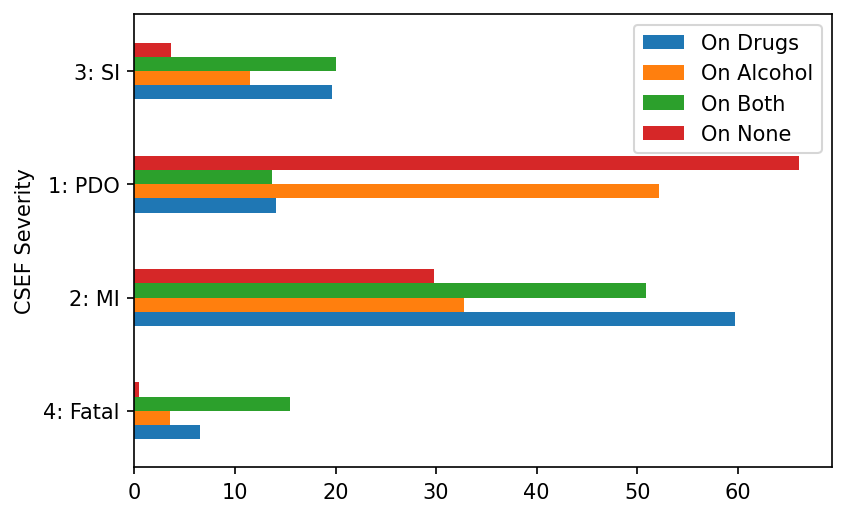

In [54]:
merged_df.set_index('CSEF Severity').plot.barh(rot=0)